In [1]:
from IPython.display import display, HTML

html_content = """
<p style='font-size: 70px; text-align: center'><b>Next Word Prediction</b></p>
<p style='font-size: 20px;'><b>Made by :- </b></p>
<p style='font-size: 23px;'>Kiran Bai</p>
<p style='font-size: 23px;'>Abdul Sattar</p>
<p style='font-size: 23px;'>Ayaz Hussain</p>
<p style='font-size: 23px;'>Shivani Thourani</p>
"""
display(HTML(html_content))


# Introduction

# Next Word Prediction, also known as Language Modeling, involves forecasting the next word in a sequence. It is a core task in natural language processing (NLP).

### More about the dataset , check

https://www.kaggle.com/datasets/dorianlazar/medium-articles-dataset


## Import necessary libraries and packages

In [2]:
import numpy as np  # Using for different problems related to numericals operations
import pandas as pd  # Using to the read the csv dataset
import tensorflow as tf
# from colorama import Back, Fore
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from termcolor import colored, cprint

## Dataset Information
---
Import Medium-articles-dataset:

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

    Towards Data Science
    UX Collective
    The Startup
    The Writing Cooperative
    Data Driven Investor
    Better Humans
    Better Marketing

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

# Load the uploaded CSV file to inspect its contents
file_path = '/content/drive/My Drive/medium_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


# Verifying the dataset's shape

In [5]:
print("Number of records: ", df.shape[0])
print("Number of fields: ", df.shape[1])

Number of records:  6508
Number of fields:  10


---
The dataset contains 10 different fields and 6,508 records, but we will focus solely on the title field for next-word prediction.

# Display titles of various articles and preprocess them

In [6]:
df["title"]

,title
0,A Beginner’s Guide to Word Embedding with Gens...
1,Hands-on Graph Neural Networks with PyTorch & ...
2,How to Use ggplot2 in Python
3,Databricks: How to Save Files in CSV on Your L...
4,A Step-by-Step Implementation of Gradient Desc...
...,...
6503,“We” vs “I” — How Should You Talk About Yourse...
6504,How Donald Trump Markets Himself
6505,Content and Marketing Beyond Mass Consumption
6506,5 Questions All Copywriters Should Ask Clients...


# Identifying null or missing values

In [7]:
df["title"].isna().sum()

0

---
# Cleaning Titles by Removing Unwanted Characters and Words
Upon examining the titles, we notice the presence of unnecessary characters and words that are not useful for prediction. In fact, these elements could negatively impact the model's accuracy, so it's essential to remove them.

In [8]:
df["title"] = df["title"].apply(lambda x: x.replace("\xa0", " "))
df["title"] = df["title"].apply(lambda x: x.replace("\u200a", " "))

In [9]:
df["title"]

,title
0,A Beginner’s Guide to Word Embedding with Gens...
1,Hands-on Graph Neural Networks with PyTorch & ...
2,How to Use ggplot2 in Python
3,Databricks: How to Save Files in CSV on Your L...
4,A Step-by-Step Implementation of Gradient Desc...
...,...
6503,“We” vs “I” — How Should You Talk About Yourse...
6504,How Donald Trump Markets Himself
6505,Content and Marketing Beyond Mass Consumption
6506,5 Questions All Copywriters Should Ask Clients...


---
# Tokenization
Tokenization is the process of assigning a unique ID to each word, creating a word index or vocabulary.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(
    oov_token="<oov>"
)  # For those words which are not found in word_index
tokenizer.fit_on_texts(df["title"])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index["<oov>"])
print("Strong: ", tokenizer.word_index["strong"])
print("And: ", tokenizer.word_index["and"])
print("Consumption: ", tokenizer.word_index["consumption"])
print("------------")
print("how the data is stored :-\n", list(tokenizer.word_index.items())[:20])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237
------------
how the data is stored :-
 [('<oov>', 1), ('to', 2), ('the', 3), ('strong', 4), ('a', 5), ('of', 6), ('how', 7), ('and', 8), ('in', 9), ('your', 10), ('markup', 11), ('for', 12), ('you', 13), ('with', 14), ('is', 15), ('—', 16), ('data', 17), ('why', 18), ('class', 19), ('h3', 20)]


---

# Converting Titles Text into Sequences and Creating an N-Gram Model
For example, consider a sentence like "I am Kiran." This will be converted into a sequence using their respective tokens: {'I': 1, 'am': 2, 'Kiran': 3}. The resulting sequence will be [1, 2, 3].

Similarly, all titles will be transformed into sequences.

Next, we will construct an n-gram model to enhance prediction accuracy.

The image below illustrates the entire process.

In [12]:
input_sequences = []
for line in df["title"]:
    token_list = tokenizer.texts_to_sequences([line])[0]
    # print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[: i + 1]
        input_sequences.append(n_gram_sequence)

print("This is What token list looks like :-", token_list)
cprint("------------", "yellow")
# print(input_sequences)
print("Total input sequences: ", len(input_sequences))
cprint("------------", "yellow")
print(list(tokenizer.word_index.items())[4])
print(list(tokenizer.word_index.items())[675])
print(list(tokenizer.word_index.items())[67])
print(list(tokenizer.word_index.items())[1])
print(list(tokenizer.word_index.items())[451])
print(list(tokenizer.word_index.items())[1517])
cprint("------------", "yellow")
print("This sentence is converted into the below sequence ::")
print(df["title"][0])
# print(len(list(tokenizer.word_index.items())))
input_sequences[:9]

This is What token list looks like :- [7, 2, 65, 5, 85, 56, 730, 550]
------------
Total input sequences:  48461
------------
('a', 5)
('beginner’s', 676)
('guide', 68)
('to', 2)
('word', 452)
('embedding', 1518)
------------
This sentence is converted into the below sequence ::
A Beginner’s Guide to Word Embedding with Gensim Word2Vec Model


[[5, 676],
 [5, 676, 68],
 [5, 676, 68, 2],
 [5, 676, 68, 2, 452],
 [5, 676, 68, 2, 452, 1518],
 [5, 676, 68, 2, 452, 1518, 14],
 [5, 676, 68, 2, 452, 1518, 14, 2455],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653],
 [5, 676, 68, 2, 452, 1518, 14, 2455, 3653, 99]]

In [13]:
import pickle

# saving
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
# Standardizing Title Lengths with Padding
All titles must have the same length. To achieve this, we first determine the maximum title length and then pad the remaining titles accordingly.

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_len = max([len(x) for x in input_sequences])
# get the maximum length sequence
max_sequence_len

40

In [15]:
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre")
)
input_sequences[8]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    5,  676,   68,
          2,  452, 1518,   14, 2455, 3653,   99], dtype=int32)

---

## Prepare features and labels

Here, we consider last element of all sequences as a label.Then, We need to perform onehot encoding on labels corresponding to total_words.

In [16]:
input_sequences[:, :]  # This is the original sequences

array([[  0,   0,   0, ...,   0,   5, 676],
       [  0,   0,   0, ...,   5, 676,  68],
       [  0,   0,   0, ..., 676,  68,   2],
       ...,
       [  0,   0,   0, ...,   5,  85,  56],
       [  0,   0,   0, ...,  85,  56, 730],
       [  0,   0,   0, ...,  56, 730, 550]], dtype=int32)

In [17]:
input_sequences[:, -1]  # This is the last element which was omitted

array([676,  68,   2, ...,  56, 730, 550], dtype=int32)

In [18]:
xs, labels = input_sequences[:, :-1], input_sequences[:, -1]
print(xs[5])
print(labels[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14


In [19]:
cprint("Performing ONE-HOT ENCODING.....", "red")
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)
print("At row-5 and col-14 ==", ys[5][14])
pd.DataFrame(ys).head(6)

Performing ONE-HOT ENCODING.....
At row-5 and col-14 == 1.0


,0,1,2,3,4,5,6,7,8,9,...,8228,8229,8230,8231,8232,8233,8234,8235,8236,8237
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

# **Architechture of Bidirectional LSTM Neural Network**

Long Short-Term Memory (LSTM) networks is an advance recurrent neural network which is apable to store order states by using its cell state feature.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam

model_150 = Sequential()
model_150.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model_150.add(LSTM(150))  # Unidirectional LSTM with 150 units
model_150.add(Dense(total_words, activation="softmax"))

adam = Adam(learning_rate=0.01)
model_150.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

history_150 = model_150.fit(xs, ys, epochs=50, verbose=1)
print(model_150)


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0881 - loss: 7.1346
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.1709 - loss: 5.7955
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2050 - loss: 4.8999
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.2579 - loss: 4.1028
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3158 - loss: 3.5208
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3563 - loss: 3.1802
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.3752 - loss: 3.0015
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.4107 - loss: 2.7395
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4276 - loss: 2.6307
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4407 - loss: 2.5406
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4571 - loss: 2.4381
Epoch 12/50
1515/15

In [32]:
model_250 = Sequential()
model_250.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model_250.add(LSTM(250))  # Unidirectional LSTM with 250 units
model_250.add(Dense(total_words, activation="softmax"))

adam = Adam(learning_rate=0.01)
model_250.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

history_250 = model_250.fit(xs, ys, epochs=50, verbose=1)
print(model_250)


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.0964 - loss: 7.0771
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.1706 - loss: 5.7738
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2084 - loss: 4.8015
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.2770 - loss: 3.8766
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.3351 - loss: 3.2773
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.3951 - loss: 2.8684
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.4234 - loss: 2.6249
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.4467 - loss: 2.5050
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4717 - loss: 2.3215
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4757 - loss: 2.3160
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.4919 - loss: 2.2313
Epoch 12

In [33]:
model_500 = Sequential()
model_500.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model_500.add(LSTM(500))  # Unidirectional LSTM with 500 units
model_500.add(Dense(total_words, activation="softmax"))

adam = Adam(learning_rate=0.01)
model_500.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

history_500 = model_500.fit(xs, ys, epochs=50, verbose=1)
print(model_500)


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.0967 - loss: 7.0912
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.1732 - loss: 5.8172
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2120 - loss: 4.7781
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.2800 - loss: 3.8291
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.3575 - loss: 3.1498
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.4232 - loss: 2.6817
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.4613 - loss: 2.4230
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.4901 - loss: 2.2585
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5052 - loss: 2.1578
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5341 - loss: 2.0158
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5488 - loss: 1.9290
Epoch 12

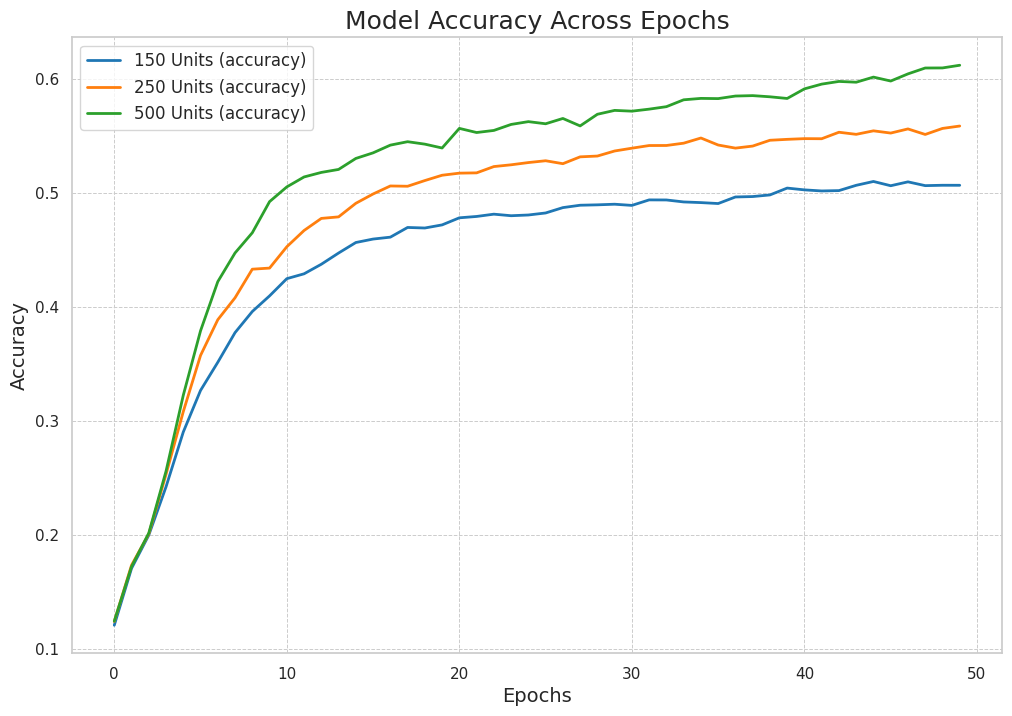

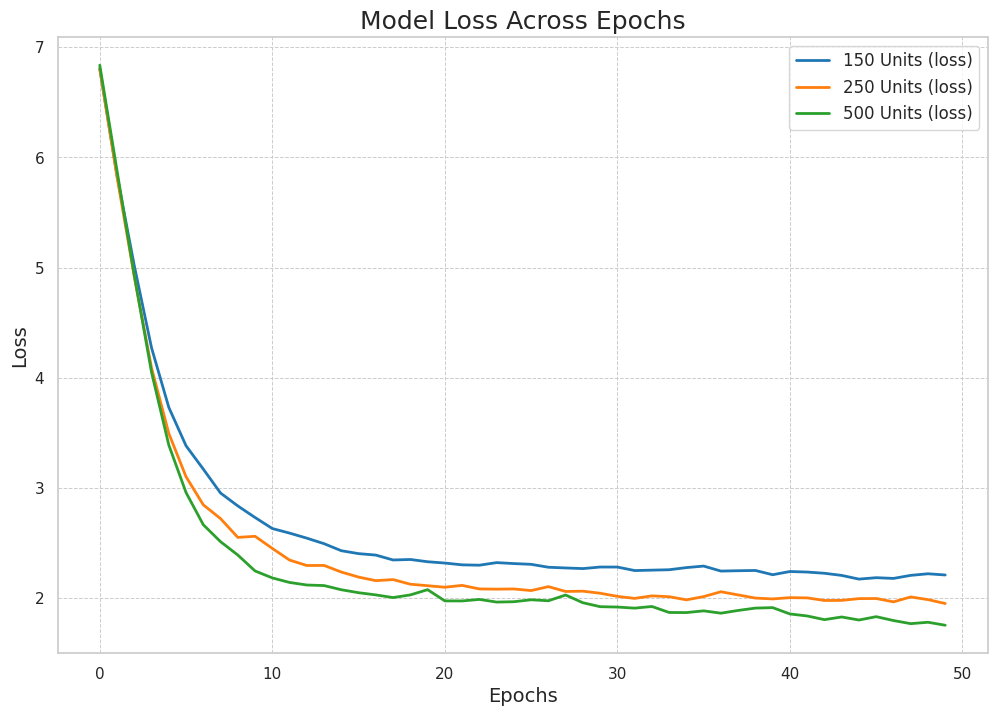

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for improved aesthetics
sns.set(style="whitegrid")

# Plotting function
def plot_results(histories, labels, metric="accuracy", colors=None):
    plt.figure(figsize=(12, 8))

    # Assign default colors if not provided
    if colors is None:
        colors = ['blue', 'orange', 'green']

    for history, label, color in zip(histories, labels, colors):
        plt.plot(history.history[metric], label=f"{label} ({metric})", color=color, linewidth=2.0)

    plt.title(f"Model {metric.capitalize()} Across Epochs", fontsize=18)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.show()

# Histories for each model
histories = [history_150, history_250, history_500]
labels = ["150 Units", "250 Units", "500 Units"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Custom colors

# Plot Accuracy
plot_results(histories, labels, metric="accuracy", colors=colors)

# Plot Loss
plot_results(histories, labels, metric="loss", colors=colors)


In [20]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation="softmax"))
adam = Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
history = model.fit(xs, ys, epochs=50, verbose=1)
# print model.summary()
print(model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.0927 - loss: 7.0748
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.1762 - loss: 5.7252
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2077 - loss: 4.8650
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.2639 - loss: 4.0638
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3201 - loss: 3.4708
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.3679 - loss: 3.0839
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4038 - loss: 2.8325
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4232 - loss: 2.6813
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4411 - loss: 2.5549
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.4611 - loss: 2.4406
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.4634 - loss: 2.4025
Epoch 12

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 39, 100)             │         823,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8238)                │       2,479,638 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,813,916 (41.25 MB)

 Trainable params: 3,604,638 (13.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,209,278 (27.50 MB)

In [114]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(250)))
model.add(Dense(total_words, activation="softmax"))
adam = Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])
history = model.fit(xs, ys, epochs=50, verbose=1)
# print model.summary()
print(model)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50


1515/1515 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.0936 - loss: 7.1841
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.1579 - loss: 6.8922
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1767 - loss: 6.4996
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.2155 - loss: 5.2346
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.2604 - loss: 4.7545
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.2895 - loss: 4.4791
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3259 - loss: 4.1686
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.3410 - loss: 4.0458
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3596 - loss: 3.8895
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.3702 - loss: 3.7687
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.3921 - loss: 3.6531
Epoch 12/50
1515/15

In [ ]:
model_Bi_500 = Sequential()
model_Bi_500.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model_Bi_500.add(Bidirectional(LSTM(500)))  # Unidirectional LSTM with 150 units
model_Bi_500.add(Dense(total_words, activation="softmax"))

adam = Adam(learning_rate=0.01)
model_Bi_500.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"])

history_Bi_500 = model_Bi_500.fit(xs, ys, epochs=50, verbose=1)
print(model_Bi_500)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - accuracy: 0.0920 - loss: 7.2336
Epoch 2/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.1622 - loss: 6.2676
Epoch 3/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - accuracy: 0.2209 - loss: 4.7017
Epoch 4/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 81s 29ms/step - accuracy: 0.2980 - loss: 3.7168
Epoch 5/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.3666 - loss: 3.0854
Epoch 6/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4308 - loss: 2.6293
Epoch 7/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4779 - loss: 2.3305
Epoch 8/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4702 - loss: 2.5149
Epoch 9/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.4664 - loss: 2.5361
Epoch 10/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 82s 29ms/step - accuracy: 0.5038 - loss: 2.2579
Epoch 11/50
1515/1515 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.5296 - loss: 2.1025
Epoch 12

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()


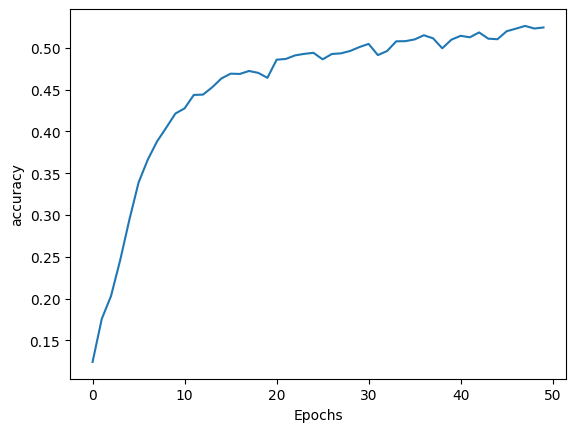

In [24]:
plot_graphs(history, "accuracy")



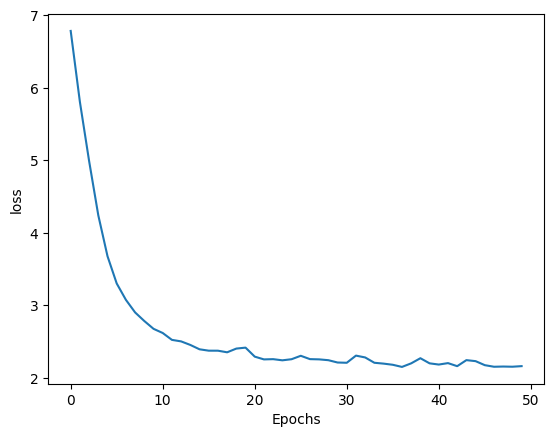

In [25]:
plot_graphs(history, "loss")

In [30]:
def output(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output("The weather today is cold")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[328]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[1926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[814]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[6634]
The weather today is cold interview prep trick to tail


Some Examples

In [55]:
def output(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output("The power of Artificial Intelligence is")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[93]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[753]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[45]
The power of Artificial Intelligence is different like well powerful need


In [59]:
def output(text):
    seed_text = text
    next_words = 5

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)


output("Some ML models perform")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[836]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[6]
Some ML models perform the 100 how managing of


In [72]:
output("Enjoy life ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[241]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[296]
Enjoy life  easy of won’t and ideas


In [73]:
def output(text):
    seed_text = text
    next_words = 10

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len - 1, padding="pre"
        )
        predicted = np.argmax(model.predict(token_list), axis=-1)
        # model.predict_classes(token_list, verbose=0)
        cprint(predicted, "red")
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [74]:
output("Some ML models perform")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[836]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[614]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[716]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[139]
Some ML models perform the 100 how managing of computing your are autoencoders who
